# WPI
# CS 539 – Machin Learning
# David Dominguez Moises
# Milestone 5 – Machine Learning

### Abstract

Identifying and mitigating DC series arc faults in PV panels is crucial for safeguarding against the risk of electrical fires, which can have catastrophic consequences. This project explores the data analysis performed on arc data from a representative electrical model in order to prove the effectivenes of machine learning models to perform arc detection. The key objectives of this proposal are to find the ideal features to be extracted from the arc data and develop a simple machine learning model that can be implemented in a system with low computation power.

### Overview and Motivation

In past years, the global energy landscape has undergone a remarkable transformation, with an increasing emphasis on sustainable and renewable sources. Solar photovoltaic (PV) systems have emerged as a pivotal player in the pursuit of clean energy solutions. As the adoption of solar technology continues to soar, it becomes imperative to address the unique challenges associated with these systems to ensure their reliability and safety.

One such challenge that demands meticulous attention is the occurrence of DC (direct current) series arcs in solar panel installations. DC series arcs, characterized by unintentional electrical discharges across series-connected components, represent a potential threat to the integrity and efficiency of solar energy systems. Identifying and mitigating these arc faults is crucial not only for enhancing the overall performance of solar panels but also for safeguarding against the risk of electrical fires, which can have catastrophic consequences.

Photovoltaic (PV) series arc detection can be challenging due to several factors associated with the nature of electrical arcs in PV systems. Series arcs occur when an unintended gap or separation occurs in the electrical path, leading to arcing between conductors. Detecting series arcs in PV systems is crucial for ensuring safety, preventing fires, and maintaining the overall reliability of the solar power installation.

Arc detection systems help prevent damage to the PV systems and to the surrounding areas, and therefore becomes a critical feature in residential systems where the quantity of customers can be really high, and the risk of critical health accidents is higher. On the other hand, given the massive quantity of residential PV systems, false detection increases the operation costs of companies and affect directly the customer experience. Every arc detection event, whether false or real, requires the system to lock out and a service team to assess the system and search for arc damage. Since the system is locked out until the service team assess the situation it affects the energy generation of the system incurring in losses related to energy utilization.

### Related Work

Arc detection is a requirement for residential PV installations and therefore the development of these algorithms is a common task for any company developing power electronics for residential systems. The paper "Parametric Study of PV Arc Fault Generation Methods and Analysis of Conducted DC Spectrum" created by Sandia National Laboratories is a good starting point to understand the complexities related to arc characterization. The fact that arcs can occur under different conditions and depend on so many independent variables was a key motivation to attempt to develop a machine learning model that can learn the patterns between arc signatures and the independent conditions under which the system is operating.

There are hundreds of papers available talking about different methods to implement arc detection, nevertheless most of these papers suffer from a lack of flexibility to adapt to different conditions in which an arc event can happen, but with the improvement of electrical systems and the amount of computing power in these systems, the deployment of more powerful algorithms has become feasible. The paper "Logistic Regression Based Arc Fault Detection in Photovoltaic Systems Under Different Conditions" was the main inspiration for this project and serve as a guide for feature processing and the type of ML models that could be applied to this problem.

### Data

The dataset was generated using a Simulink model based on the most common topology for PV DC power converters and known properties of arc events. The model consists of 4 boost converters connect to 4 individual PV panels and each can be individually controlled. Each converter is operated with a PWM moduled commanded by a duty cycle value and operating at a fixed frequency of 64kHz. The currents of each PV string are measured and added into a single signal, simulating exisiting HW architecture for arc detection in residential PV systems. The arc event is simulated by injecting gaussian noise limited to a specific frequency band with a range of 10 to 50 KHz.

The power conversion part of model is shown below:

![image.png](PwerConversionSystem.PNG)

The arc signal is generated using the band-limited white noise block from simulink and a DC offset is added to it. This arc signal is added to the current measurement coming from the power conversion system and then passed to a 250kHz discrete sampling block. The following image shows the arc signal generation part of the model:

![image.png](ArcGenerationSystem.PNG)

Due to the time scale required for the power conversion system, the ratio between simulation time and real time is very large. Each sample in the generated dataset consists of a window of 0.25 seconds sampled at 250kHz, which results in 62,500 samples for each file in the dataset. The time taken for each simulation averages to 7 minutes and therefore a big challenge in the dataset generation was the time taken to run all the simulations under different conditions.

At this stage, a higher level script was used to run the Simulink model while sweeping different parameters. Due to the difficulties in building the model and a relativlely accurate arc signal generator, the current dataset was limited to a minimum set of variations on the operating conditions. The operating conditions or independent variables comprising this dataset are the following:

1. Different values of currents for each of the 4 converters. Different permutation of theses values 0A, 3A, 5A, 6A, 7A, 8A, 12A were used for the current setting.
2. Enable and disabled conditions for each of the the converters (achieved by commanding 0A for a disabled converter)
3. Arc and no arc event for each condition
4. Transient events where individual strings experience abrupt changes of current levels.
5. Impedance difference for each of the connected strings
6. Different voltage conditions for each string

The dataset consists of 1,950 samples with the variations in the operating conditions as described in the previous list. This is the first version of the dataset and more conditions will be tested.

This first version of the dataset is under review to be published with the following details:

Dominguez, David (2024), “PV DC Series Arc Simulation Data”, Mendeley Data, V1, doi: 10.17632/pd93m3c4rz.1

### Final Research Question

In this proposal simple classification models will be evaluated to create an arc detection system. The objective of this development will be to validate if the addition of different input features in the ML model can decrease the number of false positives less than 5% while still being able to detect arcs with 100% accuracy during a certification test. The certification test will be simulated as a set of runs with a select amount of samples of the dataset that match the requirements of UL 1699B for arc detection compliant systems. The expected target value will indicate whether an arc event was present or not. The arc detection will be dependent on the operating electrical conditions of the PV DC converter which will be included in the simulation dataset.

### Exploratory data analysis

#### Data preparation

An issue that arrises with this type of systems is the behavior during start up. A common practice is to ignore the noise generated by the system for a couple of samples when the system is initializing. Since all the generated samples where recorded from the simulation starting from zeroed initial conditions, it is necessary to trim the data to ignore the first samples of the time sequence.

Since the data was generated from simulation there is no need for further cleaning.

In [2]:
import os

data_folder = '../arc_data/'

if not os.path.exists(data_folder):
    print("Folder: \"", data_folder, "\" doesnt exist")
else:
    print("Looking for data files in the relative path: \"", data_folder, "\"")

Looking for data files in the relative path: " ../arc_data/ "


In [3]:
# os.listdir(data_folder)

In [4]:
import pandas as pd

# The filename describes the condition on which the data was captured. This sample was performed as:
# PV string A current = 0A, 400V, 170uH impedance
# PV string b current = 6A, 150V, 30uH impedance
# PV string c current = 3A, 200V, 140uH impedance
# PV string d current = 5A, 330V, 150uH impedance
log_name = 'raw/test_A0_B6_C3_D5_A400_B150_C200_D330_A0.00017_B3e-05_C0.00014_D0.00015_arc1.csv'
df_raw_arc = pd.read_csv(data_folder + log_name, header=None)

log_name = 'raw/test_A0_B6_C3_D5_A400_B150_C200_D330_A0.00017_B3e-05_C0.00014_D0.00015_arc0.csv'
df_raw_noarc = pd.read_csv(data_folder + log_name, header=None)

# Add column names
df_raw_arc.columns = ['time', 'adc_data', 'currentA', 'currentB', 'currentC', 'currentD']
df_raw_noarc.columns = ['time', 'adc_data', 'currentA', 'currentB', 'currentC', 'currentD']

# Show some samples
df_raw_noarc.head()

,time,adc_data,currentA,currentB,currentC,currentD
0,0.000000,0.00000,0.0,0,0,0
1,0.000004,-0.86849,0.0,0,0,0
2,0.000008,-2.36490,0.0,0,0,0
3,0.000012,-3.80050,0.0,0,0,0
4,0.000016,-5.04220,0.0,0,0,0


In [5]:
df_raw_noarc.shape

(62501, 6)

At this point the intial samples from the file are removed:

In [6]:
start_index = 5000
df_noarc = df_raw_noarc.iloc[start_index:]
df_arc = df_raw_arc.iloc[start_index:]
df_noarc.shape

(57501, 6)

#### Basic characteristics and visualization

Additionally, a spectrogram will be generated considering buffers of 512 samples. This means individual FFTs will be generated for each buffer of 1024 and will be recorded along the time to which the FFT corresponds too.

To start understing the data a single sample will be used for the following results and plots.

Now the time domain data is plotted to see the difference between the arcing event and normal operaion:

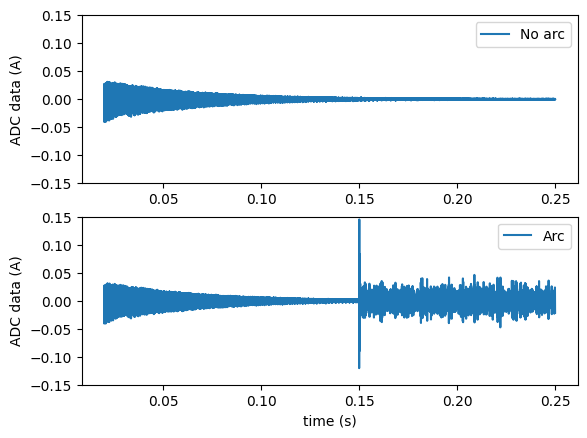

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows=2)

# Upper plot
ax1.plot(df_noarc['time'], df_noarc['adc_data'], label='No arc')
ax1.set_ylabel('ADC data (A)')
ax1.set_ylim(-0.15, 0.15)
ax1.legend()

# Lower plot
ax2.plot(df_arc['time'], df_arc['adc_data'], label='Arc')
ax2.set_ylabel('ADC data (A)')
ax2.set_ylim(-0.15, 0.15)
ax2.legend()

ax2.set_xlabel("time (s)")

plt.show()

Now the spectrogram of the data is captured and compared for bothe datsets:

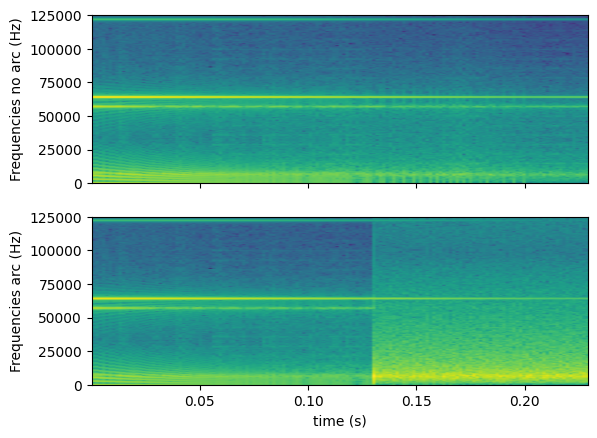

In [8]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)

Pxx, freqs, time_bins, im = ax1.specgram(df_noarc['adc_data'], Fs=250e3, NFFT=512)
ax1.set_ylabel("Frequencies no arc (Hz)")

Pxx, freqs, time_bins, im = ax2.specgram(df_arc['adc_data'], Fs=250e3, NFFT=512)
ax2.set_ylabel("Frequencies arc (Hz)")

ax2.set_xlabel("time (s)")
plt.show()

As expected, the spectogram shows theres higher magnitudes during the arc event in the range of frequencies below 60kHz.

Another useful plot for this data is to see the spectoram in 3D to understand how much higher the noise is during the arcing event.

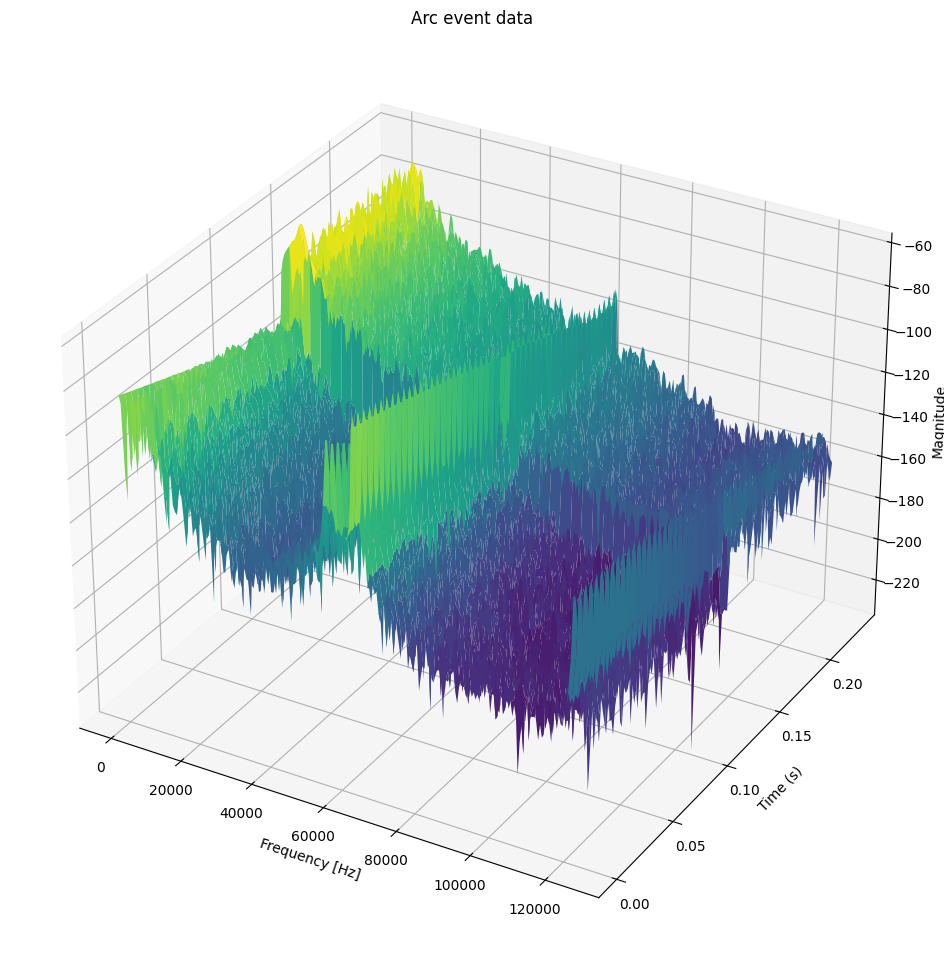

In [9]:
import numpy as np

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.plot_surface(freqs[:, None], time_bins[None, :], 10.0*np.log10(Pxx), cmap='viridis')
ax.set_title("Arc event data")
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Magnitude')
plt.show()

At this point, its also important to consider how the resolution of the FFT can affect the data visualization and its processing with a machine learning algorithm. The FFT resolution is given by: Sampling frequency/Length of window.
In this case, the resolution is 250,000/512 = 488Hz.

In order to reduce the computation time, some arc detection algorithms reduce the resolution of these frequency bins by averagin multiple bins and combining them into a single one. The following function performs this operationg and the next plot shows how the arc event looks when the resolution of the bins are reduced:

In [10]:
def reshape_spectrogram(bin_width, orig_freqs, data):
    """ 
        Based on a previously generated spectrogram, downsamples the bins to span more frequencies (lower resolution bins).
        For example: orginal spectrogram bin resolution of 150Hz per bin to a low res spectrogram of 1.5kHz per bin.
        Arguments:
        bin_width : frequency range/width of each bin
        orig_freqs : array of the end frequencies for each bin in the original spectrogram
        data : array of maginuted samples representing a time series for each frquency bin
    """

    # The number of bins is the dvision of the spectrum frequency range divided by the frequency range (width) of the bin
    number_of_bins = int(np.max(orig_freqs)/bin_width)

    _, number_of_samples = data.shape

    # Array of the frequencies of the bins
    new_freqs = np.empty((number_of_bins, 1))
    # Each frequency bin is an array of samples (time series)
    new_data = np.empty((number_of_bins, number_of_samples))

    freqs_bins_index = 0
    for i in range(number_of_bins):
        # This is the frequency 
        frequency_bin = (i+1)*bin_width

        # Find the original frequencies that would form a bin based on the new width.
        current_bin_indexes = []
        while True:

            # Check index is within array bounds
            if freqs_bins_index >= len(orig_freqs):
                break

            # Stop when the original frequency has gone beyond the desired bound for the current bin frequencies
            if orig_freqs[freqs_bins_index] > frequency_bin:
                break

            current_bin_indexes.append(freqs_bins_index)
            freqs_bins_index += 1

        start = min(current_bin_indexes)
        end = max(current_bin_indexes)
        # Get the time series of the original bins that fit in the new frquency range of the bin
        slice_of_data = data[start:end+1, :]
        # Average all the bins data at each time step. This generates a single time series for the new bin.
        new_data[i,:] = np.mean(slice_of_data, axis=0)

        new_freqs[i] = frequency_bin

    return (new_freqs, new_data)

The original number of frequency bins on the spectrogram

In [11]:
freqs.shape

(257,)

In [12]:
freqs[0:5]

array([   0.     ,  488.28125,  976.5625 , 1464.84375, 1953.125  ])

The following code processes the data to reduce the FFT resolution to 10kHz per bin:

In [13]:
bin_division = 10000
new_freqs, new_pxx = reshape_spectrogram(bin_division, freqs, Pxx)

The new spectogram has less bins spread at 10kHz width

In [14]:
new_freqs.shape

(12, 1)

In [15]:
new_freqs[0:5]

array([[10000.],
       [20000.],
       [30000.],
       [40000.],
       [50000.]])

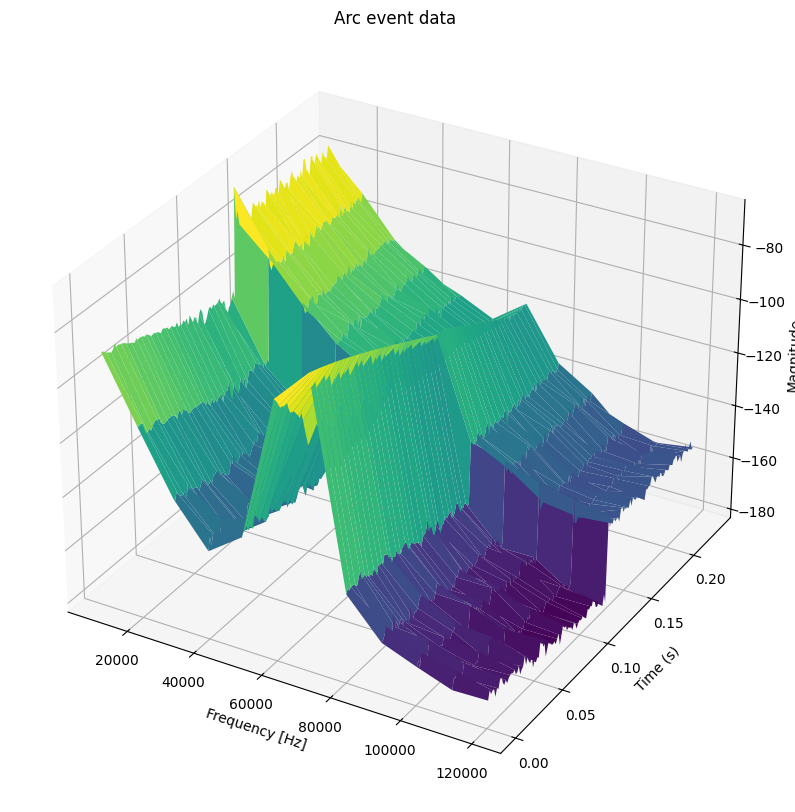

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(new_freqs, time_bins[None, :], 10.0*np.log10(new_pxx), cmap='viridis')
ax.set_title("Arc event data")
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Magnitude')
plt.show()

After performing this resolution reduction it can be observed that some peaks in noise become wider and more noticeable. This could be an issue since now the data is more contamindated by the natural noise of the system.

An important design consideration on this type converters is te selection of the switching frequency. This is the frequency at which the switching components like mosfets and diodes operate in the power conversion system. This frequency is selected based on an optimization problem that considers the size and cost of compoenents, and the efficiency of the system and the losses corresponding to the switching devices. In this case, a system with a switching frequency of 64kHz is evaluated, and therefore a spike around this frequency is expected to be measured in the sampled data.

Now we get back to the original resolution of 488Hz:

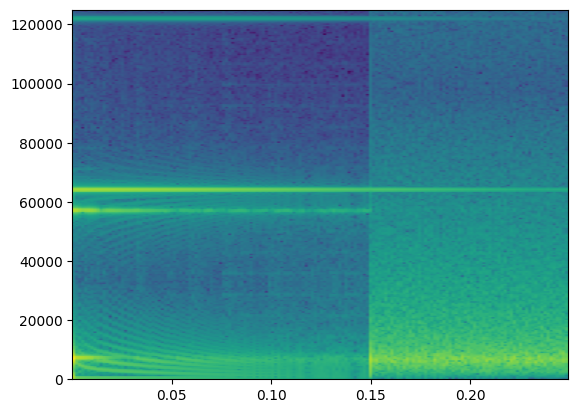

In [17]:
lower_bound = 10000
upper_bound = 50000


raw_pxx, raw_freqs, raw_time_bins, raw_im = plt.specgram(df_raw_arc['adc_data'], Fs=250e3, NFFT=512)
raw_bin_division = 488*1
raw_new_freqs, raw_new_pxx = reshape_spectrogram(raw_bin_division, raw_freqs, raw_pxx)

And we show now each bin of the FFT on its onw plot. It can be observed how the noise has a big change in dBs when the arc event starts:

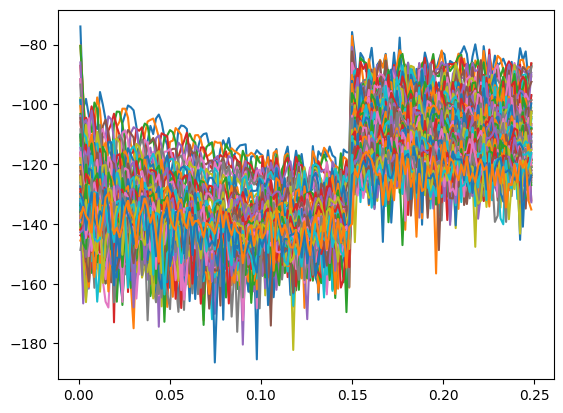

In [18]:
for i in range(len(raw_new_pxx)):
    if raw_new_freqs[i,0] > lower_bound and raw_new_freqs[i,0] < upper_bound:
        plt.plot(raw_time_bins, 10.0*np.log10(raw_new_pxx[i,:]), label="old  "+str(raw_new_freqs[i-1,0]))

# plt.legend()
plt.show()

#### Feature extraction

Based on the findings from the findings from the EDA an initial estimate of the predictor variables was created. The predictor variables are as follows:

- ADC data Time Domain mean
- ADC data Time Domain range
- ADC data Time Domain derivative
- FFT bins with a resolution of 488 Hz in the range of 10kHz to 50 KHz. This results in 82 bins
- Absolute sum of all FFT bins

The response variable is a simple boolean indicating whether a samples is an arc or not.

Since this process involves looking at a continuous real-time signal, a window of size of 7,680 samples was defined. 2 Windows per sample are selected in such way the the first window contains data before the arcing event, and the second window contains data during the arcing event. Once these windows are selected, the mentioned features are calculated for each window, and finally the rest between the 2 windows is calculated. This is meant to extract the feature delta between a normal condition and an arcing condition.

Additionaly, the minimum and maximum values for the pre-arcing window are stored to perform min-max scaling on both windows. Only the min and max values from pre-arcing are used so that both windows are scaled to the same magnitude. This scaling process was done to improve the machine learning models training performance.

The following script does the described process for each sample in the dataset and stores all features per sample in a single file for easier processing later.

As mentioned before, the full dataset is under the publication process with the following details:

Dominguez, David (2024), “PV DC Series Arc Simulation Data”, Mendeley Data, V1, doi: 10.17632/pd93m3c4rz.1

For this submission a smaller sample is provided so that part of these scripts can be tested as well.


Results stored in  preprocessed_data/processed_data.csv


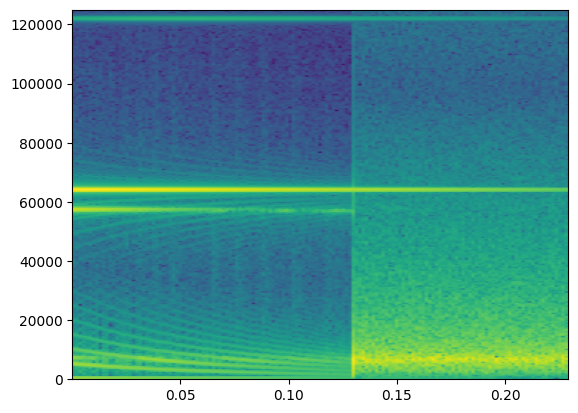

In [19]:
import batch_feature_extraction as bfe

REPROCESS_DATA = 1

if REPROCESS_DATA:
    output_filename = bfe.start_processing(data_folder + "/raw", "preprocessed_data")


In [1]:
processed_dataset = "preprocessed_data/processed_data.csv"
import pandas as pd
df = pd.read_csv(processed_dataset)
df.head()

,time,adc_data_TD_mean,adc_data_TD_range,adc_data_TD_deriv_mean,adc_data_TD_deriv_range,bin_9760.0,bin_10248.0,bin_10736.0,bin_11224.0,bin_11712.0,...,bin_46360.0,bin_46848.0,bin_47336.0,bin_47824.0,bin_48312.0,bin_48800.0,bin_49288.0,adc_data_FD_abs_sum,conditions,arc
0,0.024832,0.395348,0.054207,0.334161,0.007505,669.743783,554.360860,729.355194,1379.657102,1397.555217,...,88.247849,93.842777,43.555507,28.064263,44.304790,48.273990,31.413180,1515.944141,test_A0_B3_C7_D8_A400_B150_C430_D330_A0.00017_...,1
1,0.024832,0.027255,-0.233020,0.009722,-0.336521,0.070708,0.286445,0.107269,-0.059092,-0.102274,...,-0.028144,0.012665,-0.148304,-0.193307,-0.178195,-0.153028,0.004559,-0.170531,test_A0_B3_C3_D5_A400_B150_C200_D330_A1e-05_B0...,0
2,0.024832,0.036671,-0.186656,0.011869,-0.360143,793.628870,313.532034,443.939098,827.934697,919.718551,...,22.203284,28.675214,17.205912,9.197370,5.675724,12.051594,21.128769,447.554527,test_A0_B3_C3_D5_A400_B150_C200_D330_A1e-05_B3...,1
3,0.024832,0.375050,0.053515,0.705622,0.006947,419.488970,608.453524,708.119153,1326.257275,989.517044,...,137.299121,36.565391,24.607873,15.864469,58.764528,43.105988,60.999248,1139.584734,test_A0_B3_C3_D5_A400_B150_C200_D330_A0.00017_...,1
4,0.024832,0.248696,-0.002621,0.004769,-0.003164,-0.229801,-0.092650,-0.044742,-0.130849,-0.077289,...,-0.097380,-0.149489,-0.039109,-0.054682,0.023522,-0.109148,-0.123359,-0.120239,test_A0_B3_C7_D5_A400_B150_C200_D330_A0.00017_...,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 90 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   time                     1950 non-null   float64
 1   adc_data_TD_mean         1950 non-null   float64
 2   adc_data_TD_range        1950 non-null   float64
 3   adc_data_TD_deriv_mean   1950 non-null   float64
 4   adc_data_TD_deriv_range  1950 non-null   float64
 5   bin_9760.0               1950 non-null   float64
 6   bin_10248.0              1950 non-null   float64
 7   bin_10736.0              1950 non-null   float64
 8   bin_11224.0              1950 non-null   float64
 9   bin_11712.0              1950 non-null   float64
 10  bin_12200.0              1950 non-null   float64
 11  bin_12688.0              1950 non-null   float64
 12  bin_13176.0              1950 non-null   float64
 13  bin_13664.0              1950 non-null   float64
 14  bin_14152.0             

### Model Revision

One goal for this project is to classify arcs with Machine Learning while running the model in a lower computing power device, therefore the models that were evaluated were considered given their simplicity and low complexity.

The models considered for this problem will be:

- Multiple linear regression
- Logistic regression
- SVM with linear kernel

Since the data was created specifically for this project, the dataset was balanced between the no-arc and arc classes and therfore a simple train-tes split was done using sklearns functions.

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(['conditions', 'time', 'arc'], axis=1)
y = df['arc']

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

Then the model is trained with the processed dataset. For this milestone, results with a linear kernel SVM are shown.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.linear_model import LinearRegression

# regressor = LogisticRegression(solver='sag', max_iter=2000)
regressor = svm.SVC(kernel='linear')
# regressor = svm.SVC(kernel='rbf')
# regressor = LinearRegression()

regressor.fit(X_train,y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Then the trained model is used to perform the predictions on the test set.

In [5]:
test_prediction = regressor.predict(X_test)
train_prediction = regressor.predict(X_train)

The following plots show the results for each sample to compare the predictions agains the expected outputs. This first plot shows both predicted and expected result overlapped on the same figure.

A full overlap shows there are no differences.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

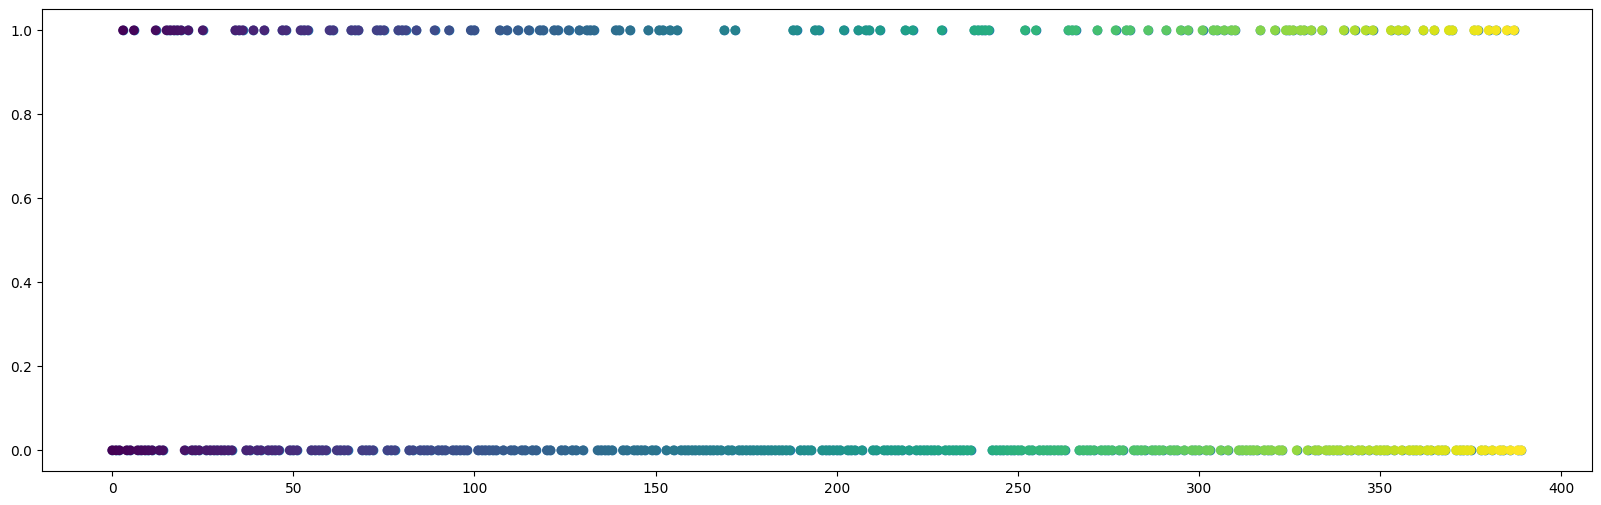

In [7]:
fig = plt.figure(figsize=(20, 6))
plt.scatter(range(len(y_test)), y_test)
plt.scatter(range(len(test_prediction)),test_prediction, c=range(len(test_prediction)))

This second plot shows the same but split in 2 different plots.

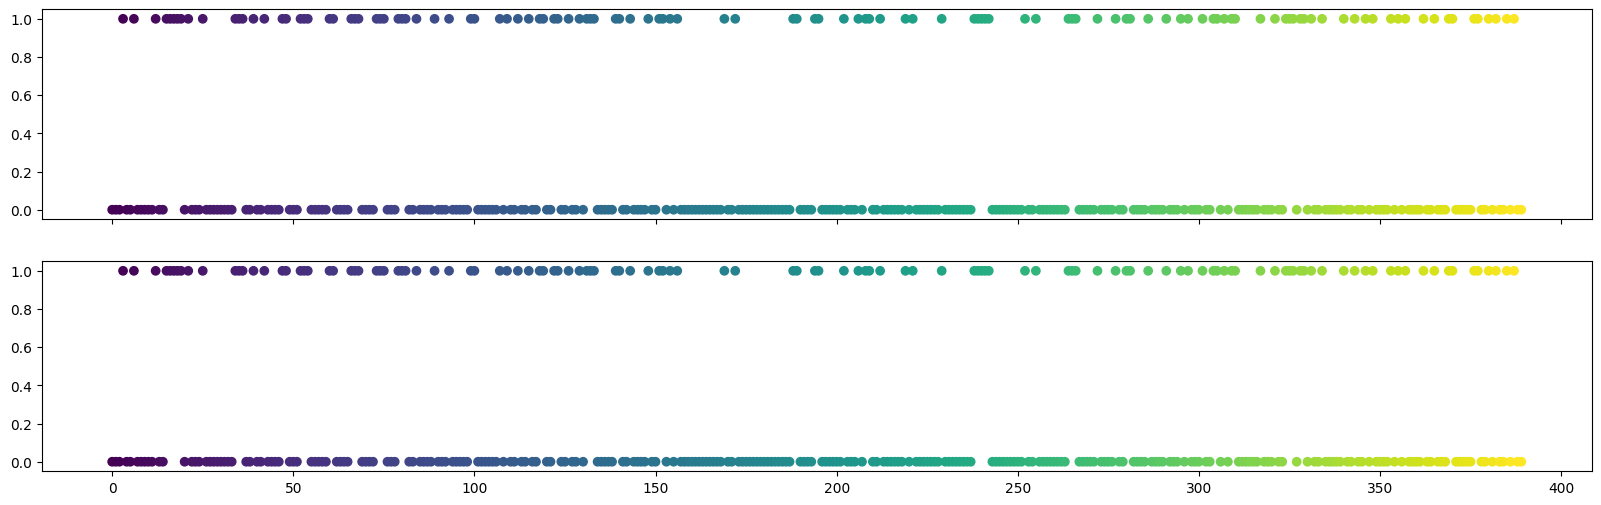

In [8]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(20,6))
ax1.scatter(range(len(test_prediction)),test_prediction, c=range(len(test_prediction)))
ax2.scatter(range(len(y_test)), y_test, c=range(len(y_test)))

With this data some initial metrics are reported:

In [9]:
from sklearn.metrics import classification_report

from sklearn import metrics

print(metrics.confusion_matrix(y_test, test_prediction))
print(classification_report(y_test,test_prediction))

[[269   0]
 [  0 121]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       269
           1       1.00      1.00      1.00       121

    accuracy                           1.00       390
   macro avg       1.00      1.00      1.00       390
weighted avg       1.00      1.00      1.00       390



To hav some initial understanding of the model coefficients and if there are some more significance we can plot them as follows.

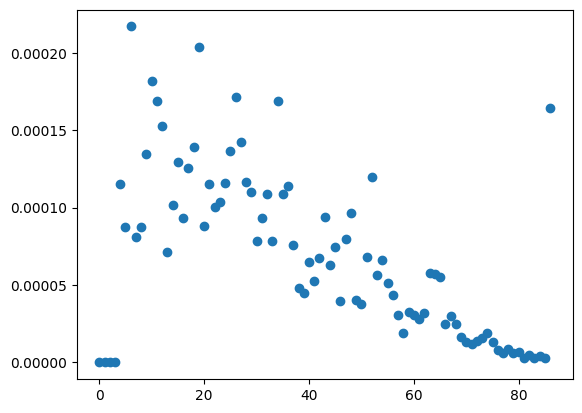

In [10]:
original_coefs = regressor.coef_[0]
plt.scatter(range(len(original_coefs)),original_coefs)

From the previous plot it can be observed that some features have weights close to 0 and probably may have very little effect on the prediction task.

The next step is to perform feature reduction, since the initial amount of features is very big and increases the computation requirements of the process. For this, the recursive feature elemination functions from sklearn were used, specifically RFECV offers the ability to determine a minimum number of features to select and the process will find the optimal number of features for the best performance. The performance for each iteration is done with a cross-validation process of 5 folds.

In [11]:
from sklearn.feature_selection import RFE, RFECV

rfe = RFECV(estimator=regressor, min_features_to_select=5, step=1)
rfe.fit(X_train, y_train)
print(rfe.ranking_)

[82 81 83 80  4 25  1 31 17 10  3  1  7 36 16  8 26  1 14  6 15 11 20 23
  9 13  2 19 29  5 22  1 12 34 18 32 21 35 48 49 39 45 38 28 41 33 52 30
 27 51 53 37 24 44 40 47 50 57 63 54 56 59 55 42 43 46 61 58 60 64 68 69
 66 65 62 67 71 73 70 74 72 78 75 77 76 79  1]


In [12]:
feaure_indices = rfe.get_support(indices=True)
feaure_indices

array([ 6, 11, 17, 31, 86])

After performing this feature selection process, the model can be retrained to evaluate performance.

In [13]:
X_train_short = X_train.iloc[:, feaure_indices]
X_test_short = X_test.iloc[:, feaure_indices]
regressor.fit(X_train_short,y_train)

test_prediction = regressor.predict(X_test_short)
train_prediction = regressor.predict(X_train_short)

Features used:

In [14]:
X_train_short.columns

Index(['bin_10736.0', 'bin_13176.0', 'bin_16104.0', 'bin_22936.0',
       'adc_data_FD_abs_sum'],
      dtype='object')

### Full Analysis

The following results show the model performance considering the previous analysis to reduce the number of features used in the model.

The following plot shows the results for all samples in the testing set, where 1 indicates an arc was detected and a 0 means no arc detected. In the same plot the expected values from the test set are superimposed on the plot.

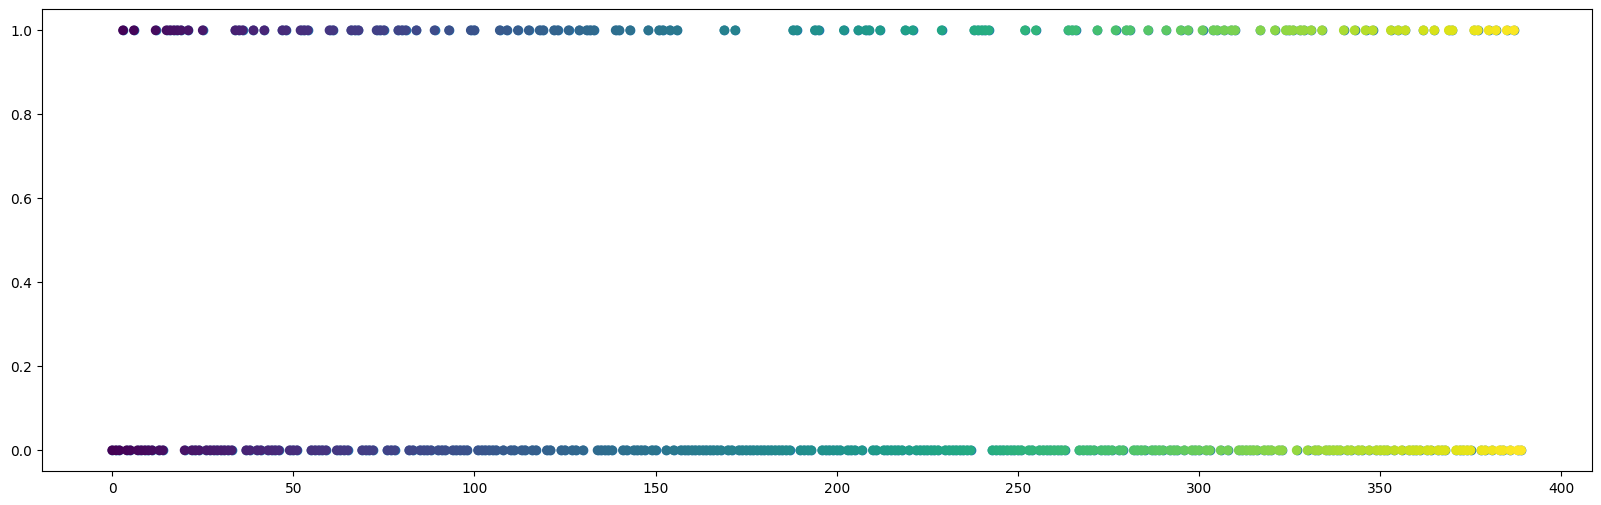

In [15]:
fig = plt.figure(figsize=(20, 6))
plt.scatter(range(len(y_test)), y_test)
plt.scatter(range(len(test_prediction)),test_prediction, c=range(len(test_prediction)))

The following plot shows the final weights of the input features copmaring the original features and the reduced set of features used on the final model.

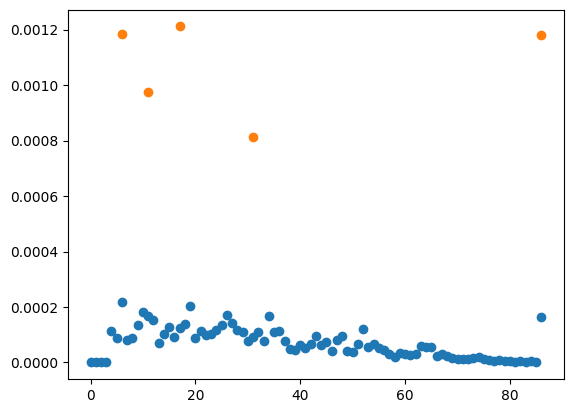

In [16]:
original_dataset_column_indexes = []
for name in X_train_short.columns.to_list():
    original_dataset_column_indexes.append(X.columns.get_loc(name))

plt.scatter(range(len(original_coefs)),original_coefs)
plt.scatter(original_dataset_column_indexes,regressor.coef_[0])

Finally a confusion matrix is reported below as well as some standard metrics for this binary classification problem.

[[269   0]
 [  0 121]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       269
           1       1.00      1.00      1.00       121

    accuracy                           1.00       390
   macro avg       1.00      1.00      1.00       390
weighted avg       1.00      1.00      1.00       390



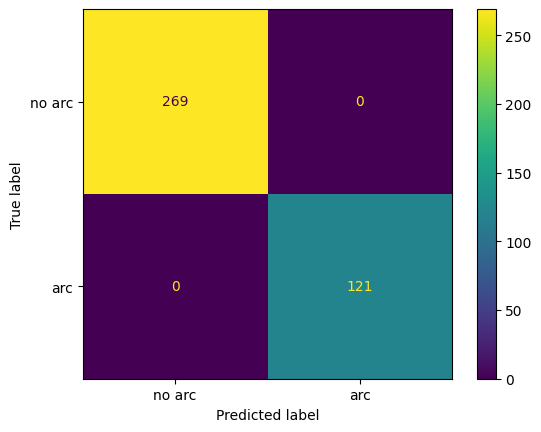

In [17]:
confusion_matrix = metrics.confusion_matrix(y_test, test_prediction)
print(confusion_matrix)
print(classification_report(y_test,test_prediction))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['no arc', 'arc'])
cm_display.plot()
plt.show()

These results are promising since the models that were tried achieved 100% accuracy with the current data set. Also the tested models align with the purpose of the project, which is to have a simple model capabale of running on a low comuting power system, and in this case the models were all linear calculations that would not require long calculations or specific HW airthmetic components.

Feature reduction showed a great improvement in the simplicity of the model which also results in faster computation and lower memory requirements.

It is important to note that the dataset used so far contains very ideal data where the arcs show similar magnitudes in all conditions, and therefore the model was able to fit perfectly this behavior and achieve 100% accuracy. To get a better idea of the model's performance in the real world, it will be needed to add corner cases in the electrical simulation.

### Final Considerations

As mentioned in the previous section, one key part will be to add more data in the dataset to get a better understanding of the model's performance. Once this is done, more analysis will be perform if there is any model that would be optimal based on performance and complexity.

Next analysis steps would include:

- Cross-validation performance comparison between different models
- RFECV for all models to see if there are any benefits from using a specific model
- Create a probability/confidence metric to understand how much an arc relates to an ideal arc. This would help understand better false positives for solar systems in the field.